In [1]:
import model_utils
import pandas as pd

merged_hornsea = pd.read_parquet("./data/preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("./data/preprocessed_pes_with_energy.parquet")

In [2]:
import importlib
import Preprocessing
importlib.reload(Preprocessing)



feature_engineerer_wind = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = Preprocessing.FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = Preprocessing.FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = Preprocessing.FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

INFO:root:No features found to onehotencode.


### __Wind Energy Forecast__

__baseline__

In [3]:
import model_utils
import numpy as np
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_wind\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_wind\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.3 to qr_model_wind\qr_model_quantile_0.3.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_wind\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_wind\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_wind\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7 to qr_model_wind\qr_model_quantile_0.7.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_wind\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_wind\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 29.5486527358065


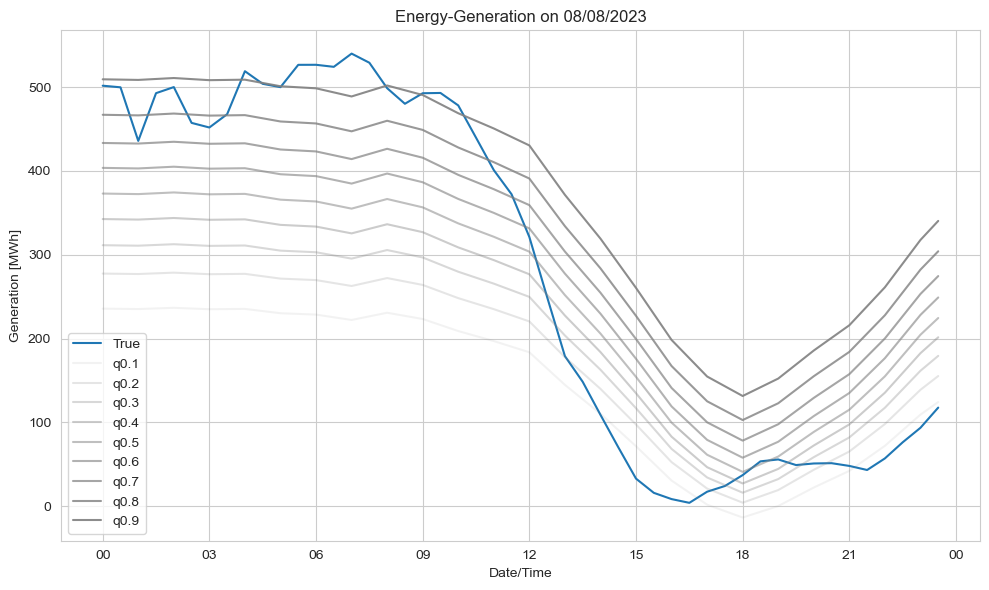

In [4]:
qr_model_wind.plot_quantils(feature_engineerer_wind_baseline.y_test.index, qr_model_wind.q_predictions, quantiles=quantiles, year=2023, month=8, day=8)

__xgboost__

In [5]:
importlib.reload(model_utils)
import numpy as np

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

model_save_dir_xgboost = "xgboost_model_wind"
hyperparams = {
            # Use the quantile objective function.
            "objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 8
        }




xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False, hyperparams=hyperparams, num_boost_round=45, early_stopping_rounds=10)
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:97.92828	Val-quantile:88.89174
[1]	Train-quantile:96.87878	Val-quantile:87.93583
[2]	Train-quantile:95.83862	Val-quantile:86.98682
[3]	Train-quantile:94.81460	Val-quantile:86.05301
[4]	Train-quantile:93.80475	Val-quantile:85.13884
[5]	Train-quantile:92.80424	Val-quantile:84.23718
[6]	Train-quantile:91.81529	Val-quantile:83.34579
[7]	Train-quantile:90.84116	Val-quantile:82.46333
[8]	Train-quantile:89.87984	Val-quantile:81.59556
[9]	Train-quantile:88.92858	Val-quantile:80.73658
[10]	Train-quantile:87.98889	Val-quantile:79.88929
[11]	Train-quantile:87.06215	Val-quantile:79.05444
[12]	Train-quantile:86.14434	Val-quantile:78.22483
[13]	Train-quantile:85.23799	Val-quantile:77.40748
[14]	Train-quantile:84.34353	Val-quantile:76.59980
[15]	Train-quantile:83.45908	Val-quantile:75.80448
[16]	Train-quantile:82.58592	Val-quantile:75.01692
[17]	Train-quantile:81.72226	Val-quantile:74.23873
[18]	Train-quantile:80.86965	Val-quantile:73.47289
[19]	Train-quantile:80.02884	Val-quantile

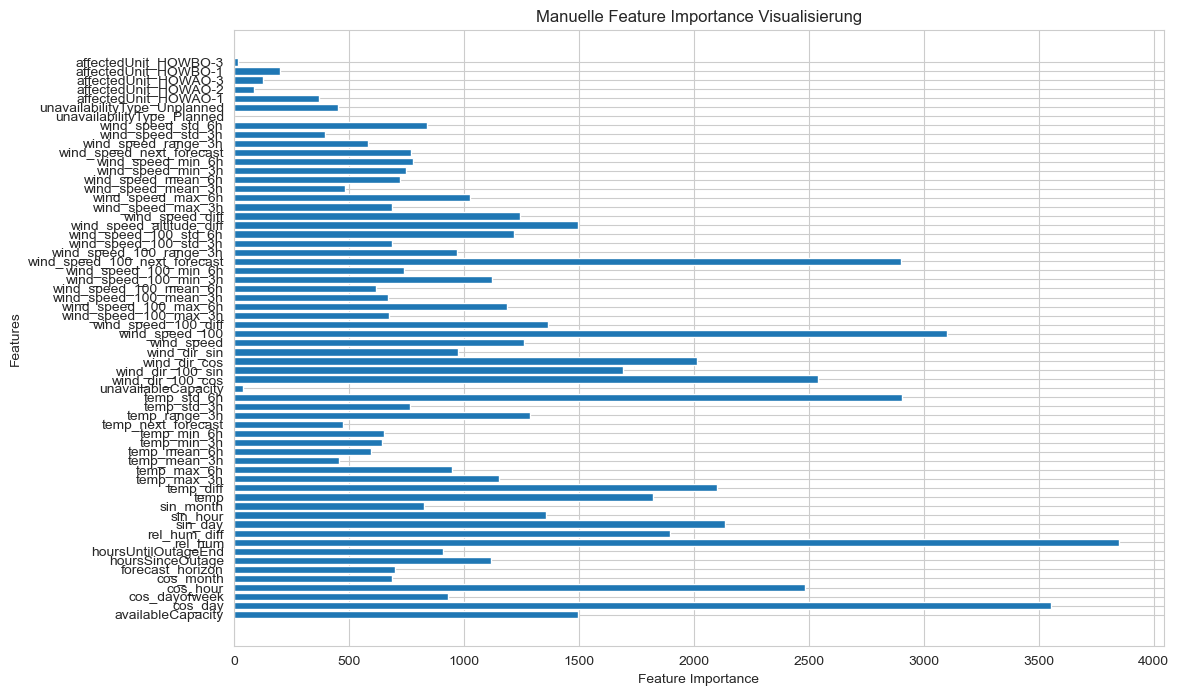

In [6]:
xgboost_model_wind.plot_feature_importance()

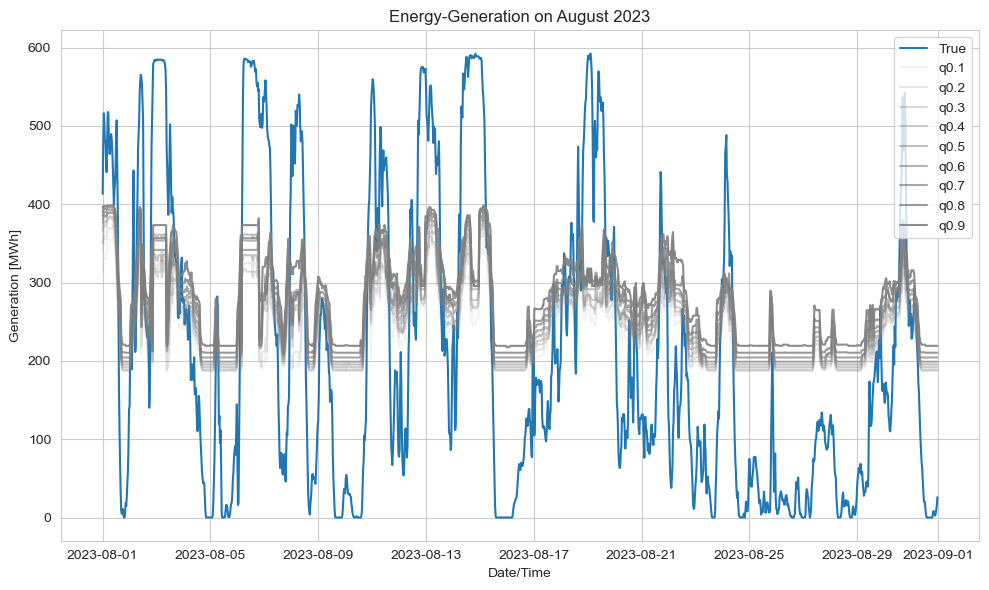

In [7]:
xgboost_model_wind.plot_quantils(daterange=feature_engineerer_wind.y_test.index, y=xgboost_model_wind.q_predictions, quantiles=quantiles, year=2023, month=8)

### __Solar Energy Forecast__

__baseline modell__

In [8]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_solar\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_solar\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.3 to qr_model_solar\qr_model_quantile_0.3.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_solar\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_solar\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_solar\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7 to qr_model_solar\qr_model_quantile_0.7.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_solar\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_solar\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 15.253271903353985


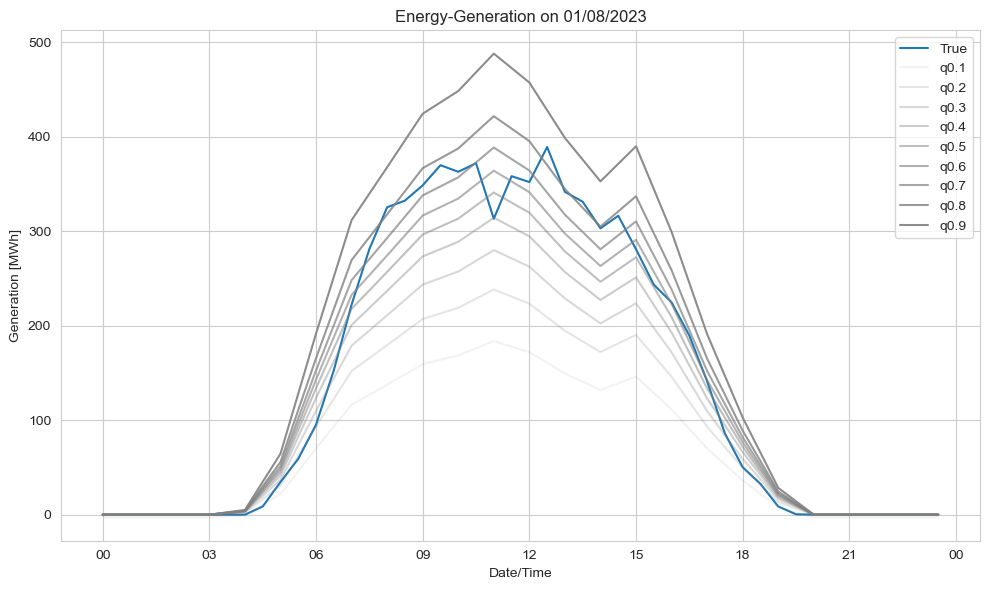

In [9]:
qr_model_solar.plot_quantils(daterange=feature_engineerer_solar_baseline.y_test.index, y=qr_model_solar.q_predictions, quantiles=quantiles, year=2023, month=8, day=1)

__xgboost__

In [10]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

model_save_dir_xgboost = "xgboost_model_solar"

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:44.08710	Val-quantile:89.95033
[1]	Train-quantile:42.03996	Val-quantile:86.05491
[2]	Train-quantile:40.15760	Val-quantile:82.27750
[3]	Train-quantile:38.39213	Val-quantile:78.74011
[4]	Train-quantile:36.76346	Val-quantile:75.33538
[5]	Train-quantile:35.21170	Val-quantile:72.08230
[6]	Train-quantile:33.74776	Val-quantile:68.96714
[7]	Train-quantile:32.34922	Val-quantile:66.00327
[8]	Train-quantile:31.01233	Val-quantile:63.15234
[9]	Train-quantile:29.73973	Val-quantile:60.44455
[10]	Train-quantile:28.53631	Val-quantile:57.85607
[11]	Train-quantile:27.39519	Val-quantile:55.40058
[12]	Train-quantile:26.32350	Val-quantile:53.00841
[13]	Train-quantile:25.29117	Val-quantile:50.79924
[14]	Train-quantile:24.31632	Val-quantile:48.64392
[15]	Train-quantile:23.39352	Val-quantile:46.61919
[16]	Train-quantile:22.51412	Val-quantile:44.65922
[17]	Train-quantile:21.67975	Val-quantile:42.82100
[18]	Train-quantile:20.88930	Val-quantile:41.07388
[19]	Train-quantile:20.14059	Val-quantile

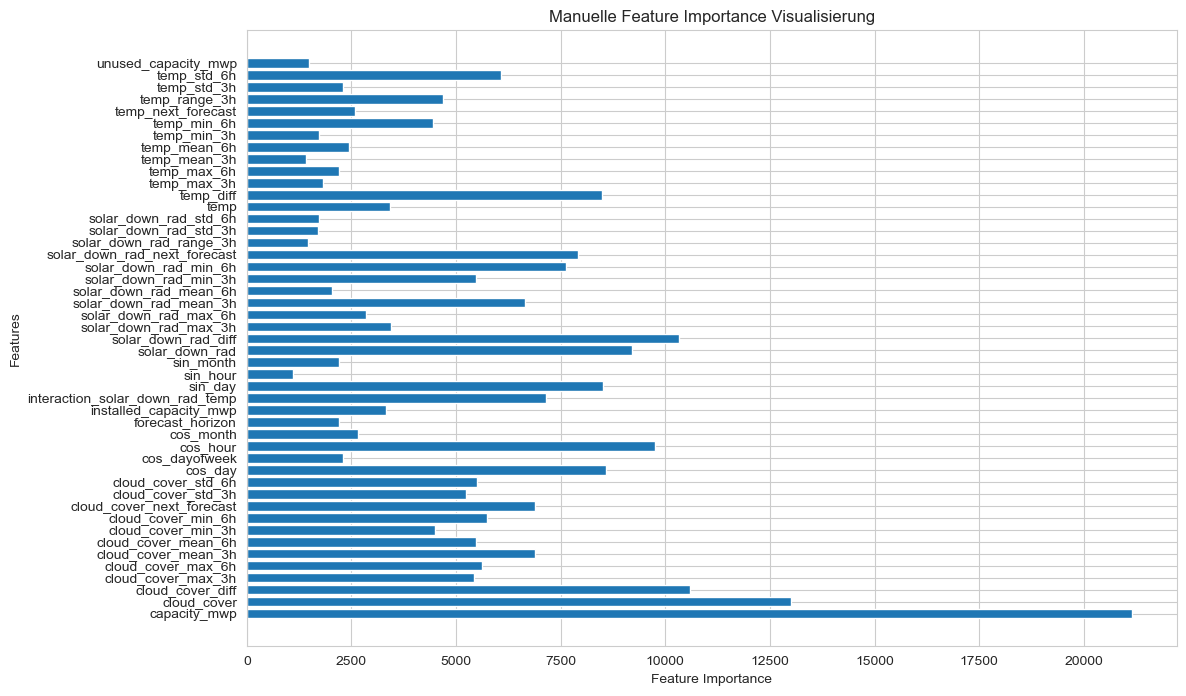

In [11]:
xgboost_model_solar.plot_feature_importance()

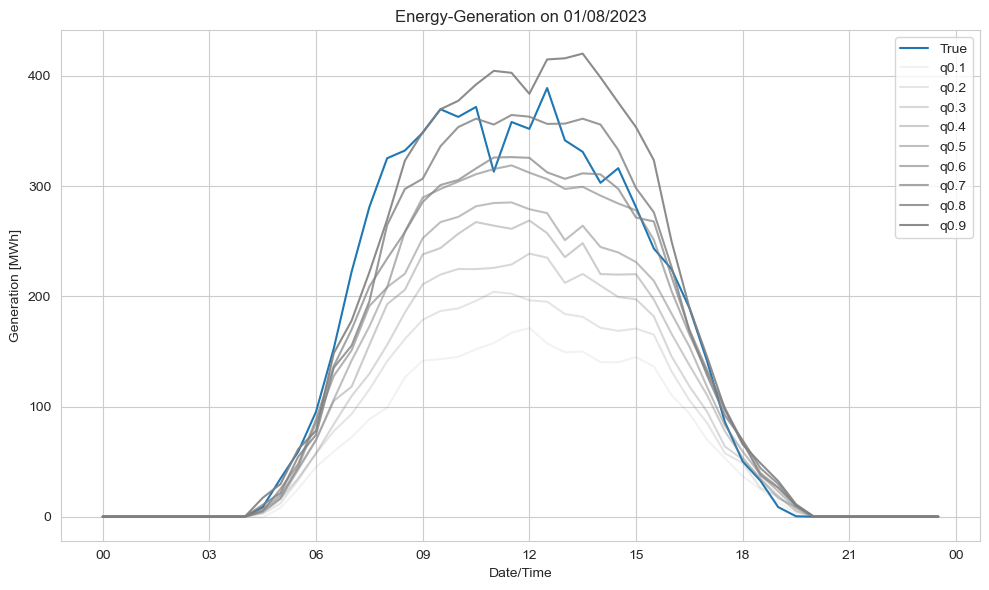

In [12]:
xgboost_model_solar.plot_quantils(daterange=feature_engineerer_solar.y_test.index, y=xgboost_model_solar.q_predictions, quantiles=quantiles, year=2023, month=8, day=1)

### __Lightgbm implementation__

In [13]:
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_wind"

lgbm_model_wind = model_utils.LGBMRegressorModel(feature_engineerer_wind, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_wind.pinball_score()}")

[LightGBM] [Info] Total Bins 11963
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 66
[LightGBM] [Info] Start training from score 9.924001
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 9.77323	valid's quantile: 11.6876
[100]	train's quantile: 8.28087	valid's quantile: 11.6754
Early stopping, best iteration is:
[71]	train's quantile: 9.01414	valid's quantile: 11.5612
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_wind\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 11963
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 66
[LightGBM] [Info] Start training from score 46.169998
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 13.7512	valid's quantile: 17.9513
[100]	train's quantile: 12.1263	valid's quantile: 18.0026
Early stopping, best iteration is:
[69]	train's quantile: 13.0298	valid's quantile: 17.8289
Saved Qu

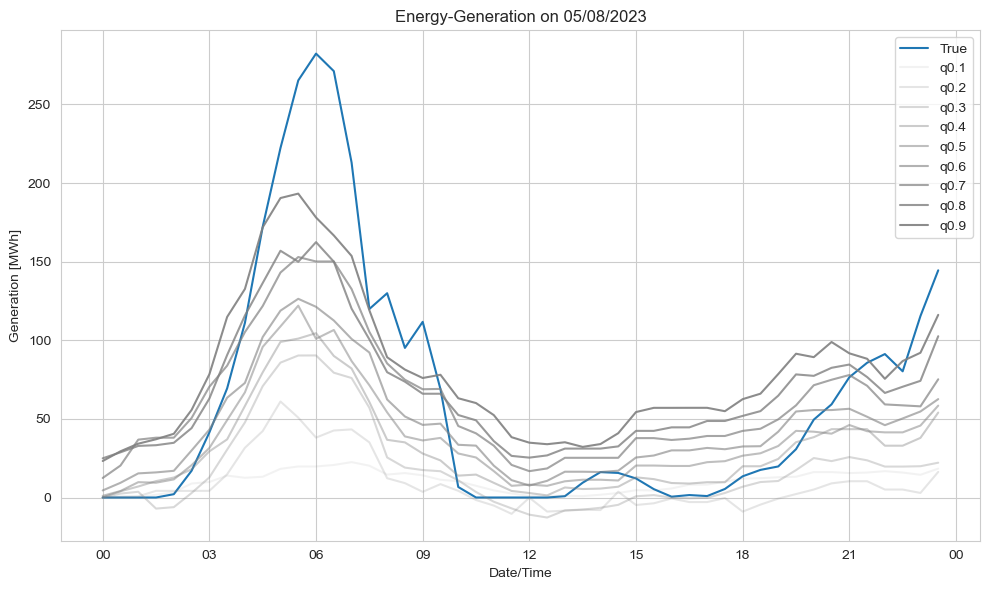

In [14]:
lgbm_model_wind.plot_quantils(feature_engineerer_wind.y_test.index, lgbm_model_wind.q_predictions, quantiles, month=8, day=5)

In [15]:
quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

# Specify model save directory
model_save_dir_qr = "lgbm_model_solar"

lgbm_model_solar = model_utils.LGBMRegressorModel(feature_engineerer_solar, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
lgbm_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {lgbm_model_solar.pinball_score()}")

[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 4.82569	valid's quantile: 6.40726
[100]	train's quantile: 3.79819	valid's quantile: 5.73256
Early stopping, best iteration is:
[94]	train's quantile: 3.8437	valid's quantile: 5.71441
Saved Quantile Regressor model for quantile 0.1 to lgbm_model_solar\qr_model_quantile_0.1.pkl
[LightGBM] [Info] Total Bins 10364
[LightGBM] [Info] Number of data points in the train set: 29231, number of used features: 47
Training until validation scores don't improve for 50 rounds
[50]	train's quantile: 6.96261	valid's quantile: 9.40234
[100]	train's quantile: 5.68551	valid's quantile: 9.03766
Early stopping, best iteration is:
[81]	train's quantile: 5.91077	valid's quantile: 8.99938
Saved Quantile Regressor model for quantile 0.2 to lgbm_model_solar\qr_model_quantile_0.2.pkl
[LightGBM] [Info] Tot

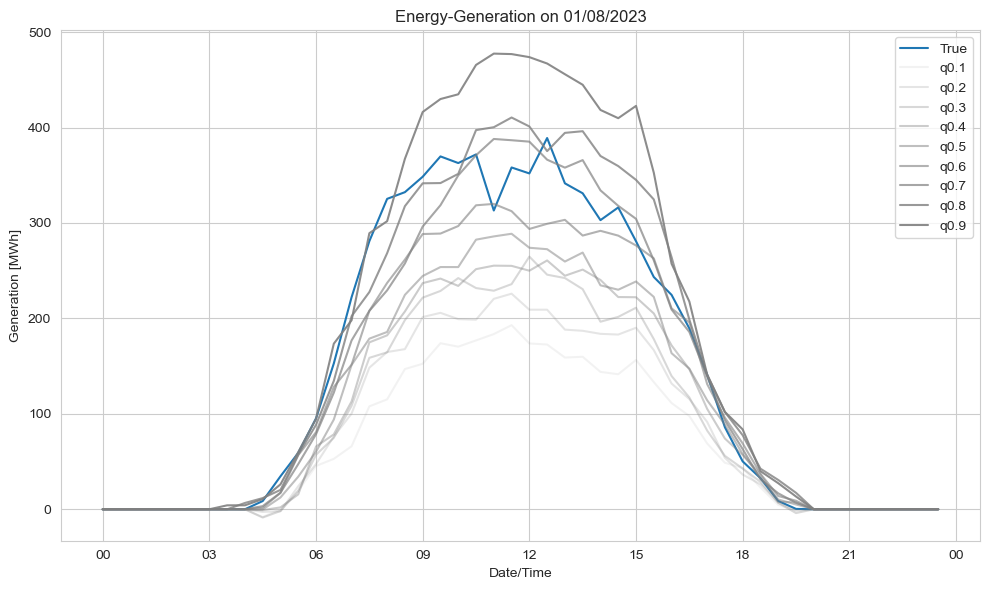

In [16]:
lgbm_model_solar.plot_quantils(feature_engineerer_solar.y_test.index, lgbm_model_solar.q_predictions, quantiles, year=2023, month=8, day=1)

In [20]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

nn_wind = neural_networks.Trainer(feature_engineerer_wind, neural_networks.q_model,quantiles, in_shape=67)
nn_wind.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 282.6741943359375
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 224.7196807861328
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 205.2104949951172
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 195.2860870361328
40. epoche startet: 
41. epoche startet: 
42. epoche start

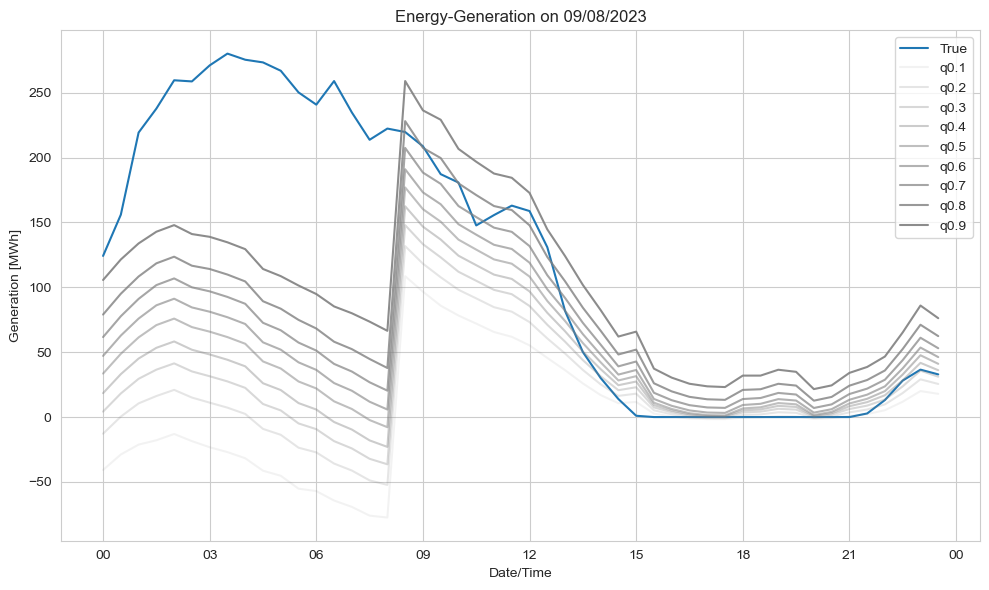

In [21]:
nn_wind.plot_quantils(feature_engineerer_wind.y_test.index, nn_wind.q_prediction_nn, quantiles, day=9)

In [22]:
import neural_networks
importlib.reload(neural_networks)
from functools import partial
from itertools import chain
import torch
import torch.nn as nn

quantiles = np.arange(0.1, 1.0, 0.1)
quantiles = np.round(quantiles, 1)

nn_solar = neural_networks.Trainer(feature_engineerer_solar, neural_networks.q_model, quantiles, in_shape=48)
nn_solar.train_and_test()

0. epoche startet: 
1. epoche startet: 
2. epoche startet: 
3. epoche startet: 
4. epoche startet: 
5. epoche startet: 
6. epoche startet: 
7. epoche startet: 
8. epoche startet: 
9. epoche startet: 
Epoch 10: 88.36112976074219
10. epoche startet: 
11. epoche startet: 
12. epoche startet: 
13. epoche startet: 
14. epoche startet: 
15. epoche startet: 
16. epoche startet: 
17. epoche startet: 
18. epoche startet: 
19. epoche startet: 
Epoch 20: 84.14485931396484
20. epoche startet: 
21. epoche startet: 
22. epoche startet: 
23. epoche startet: 
24. epoche startet: 
25. epoche startet: 
26. epoche startet: 
27. epoche startet: 
28. epoche startet: 
29. epoche startet: 
Epoch 30: 81.55792236328125
30. epoche startet: 
31. epoche startet: 
32. epoche startet: 
33. epoche startet: 
34. epoche startet: 
35. epoche startet: 
36. epoche startet: 
37. epoche startet: 
38. epoche startet: 
39. epoche startet: 
Epoch 40: 81.18134307861328
40. epoche startet: 
41. epoche startet: 
42. epoche start

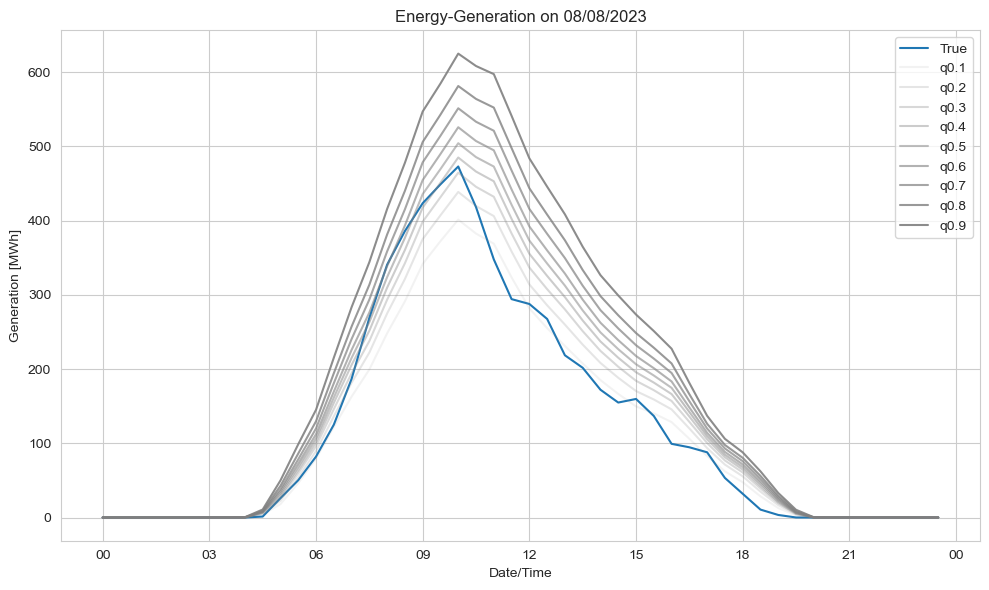

In [23]:
nn_solar.plot_quantils(feature_engineerer_solar.y_test.index, nn_solar.q_prediction_nn, quantiles, day=8)